# ThisPokemonDoesNotExist
[github repo](https://github.com/Zer0Nu11/ThisPokemonDoesNotExist)

In [11]:
# install libs
! pip install -q pandas numpy matplotlib tensorflow opencv-python

In [12]:
# ! rm -rf images images_soup archive.zip samples generated_pokemons

In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download dataset

In [4]:
# ! git clone https://github.com/Zer0Nu11/ThisPokemonDoesNotExist.git
! wget https://github.com/Zer0Nu11/ThisPokemonDoesNotExist/raw/main/dataset/archive.zip -O archive.zip
! unzip -u archive.zip
! mkdir images_soup
! mkdir samples
! mkdir generated_pokemons

--2022-10-22 15:35:43--  https://github.com/Zer0Nu11/ThisPokemonDoesNotExist/raw/main/dataset/archive.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Zer0Nu11/ThisPokemonDoesNotExist/main/dataset/archive.zip [following]
--2022-10-22 15:35:44--  https://raw.githubusercontent.com/Zer0Nu11/ThisPokemonDoesNotExist/main/dataset/archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60660766 (58M) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>]  57.85M   202MB/s    in 0.3s    

2022-10-22 15:35:44 (202 MB/s) - ‘archive.zip’ saved [60660766/60660766]


## Imports

In [5]:
import os
import numpy as np
import cv2
from glob import glob
from matplotlib import pyplot
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

## Load dataset

In [17]:
IMG_H = 128
IMG_W = 128
IMG_C = 3
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

import shutil

source = "images"
destination = "images_soup"
images_path = glob("images_soup/*")
model_path = "saved_model/"
directories = os.listdir(source)
id = 0
for dir in directories:
  files=os.listdir(source+'/'+dir)
  for file in files:
    os.rename(source+'/'+dir+'/'+file, source+'/'+dir+'/'+f'{id}.jpg')
    shutil.copy2(source+'/'+dir+'/'+f'{id}.jpg', destination)
    id+=1

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img, (IMG_H, IMG_W))
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    return img

def tf_dataset(images_path, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(images_path)
    dataset = dataset.shuffle(buffer_size=10240)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [18]:
len(os.listdir(destination)) # total number of images

7494

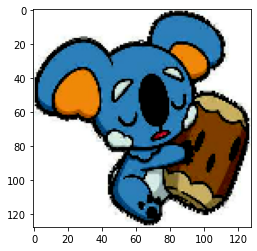

In [19]:
arr_ = np.squeeze(load_image("images_soup/1001.jpg")) # you can give axis attribute if you wanna squeeze in specific dimension
pyplot.imshow(arr_)
# pyplot.show()

## Model

In [20]:
def deconv_block(inputs, num_filters, kernel_size, strides, bn=True):
    x = Conv2DTranspose(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding="same",
        strides=strides,
        use_bias=False
        )(inputs)

    if bn:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
    return x


def conv_block(inputs, num_filters, kernel_size, padding="same", strides=2, activation=True):
    x = Conv2D(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding=padding,
        strides=strides,
    )(inputs)

    if activation:
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.3)(x)
    return x

def build_generator(latent_dim):
    f = [2**i for i in range(5)][::-1]
    filters = 32
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides

    noise = Input(shape=(latent_dim,), name="generator_noise_input")

    x = Dense(f[0] * filters * h_output * w_output, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((h_output, w_output, 16 * filters))(x)

    for i in range(1, 5):
        x = deconv_block(x,
            num_filters=f[i] * filters,
            kernel_size=5,
            strides=2,
            bn=True
        )

    x = conv_block(x,
        num_filters=3,  ## Change this to 1 for grayscale.
        kernel_size=5,
        strides=1,
        activation=False
    )
    fake_output = Activation("tanh")(x)

    return Model(noise, fake_output, name="generator")

def build_discriminator():
    f = [2**i for i in range(4)]
    image_input = Input(shape=(IMG_H, IMG_W, IMG_C))
    x = image_input
    filters = 64
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides

    for i in range(0, 4):
        x = conv_block(x, num_filters=f[i] * filters, kernel_size=5, strides=2)

    x = Flatten()(x)
    x = Dense(1)(x)

    return Model(image_input, x, name="discriminator")

class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for _ in range(2):
            ## Train the discriminator
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            generated_images = self.generator(random_latent_vectors)
            generated_labels = tf.zeros((batch_size, 1))

            with tf.GradientTape() as ftape:
                predictions = self.discriminator(generated_images)
                d1_loss = self.loss_fn(generated_labels, predictions)
            grads = ftape.gradient(d1_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

            ## Train the discriminator
            labels = tf.ones((batch_size, 1))

            with tf.GradientTape() as rtape:
                predictions = self.discriminator(real_images)
                d2_loss = self.loss_fn(labels, predictions)
            grads = rtape.gradient(d2_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        ## Train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as gtape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = gtape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d1_loss": d1_loss, "d2_loss": d2_loss, "g_loss": g_loss}

## Load pretrained model

In [ ]:
! wget https://github.com/Zer0Nu11/ThisPokemonDoesNotExist/raw/main/dataset/archive.zip
! wget https://github.com/Zer0Nu11/ThisPokemonDoesNotExist/raw/main/dataset/archive.zip

## Train

In [ ]:
def save_plot(examples, epoch, n):
    # Images gen callback
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        pyplot.subplot(n, n, i+1)
        pyplot.axis("off")
        pyplot.imshow(examples[i])  ## pyplot.imshow(np.squeeze(examples[i], axis=-1))
    filename = f"samples/generated_plot_epoch-{epoch}.png"
    pyplot.savefig(filename)
    pyplot.close()

def draw_gif():
    # Callback history into gif
    import glob
    from PIL import Image

    # filepaths
    fp_in = "samples/generated_plot_epoch-*.png"
    fp_out = model_path+"train.gif"

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
    img = next(imgs)  # extract first image from iterator
    img.save(fp=fp_out, format='GIF', append_images=imgs,
            save_all=True, duration=200, loop=0)

In [ ]:
## Hyperparameters
batch_size = 128
latent_dim = 128
num_epochs = 5

d_model = build_discriminator()
g_model = build_generator(latent_dim)

d_model.load_weights(model_path+"d_model_128.h5")
g_model.load_weights(model_path+"g_model_128.h5")

d_model.summary()
g_model.summary()

gan = GAN(d_model, g_model, latent_dim)

bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
gan.compile(d_optimizer, g_optimizer, bce_loss_fn)

images_dataset = tf_dataset(images_path, batch_size)

n_samples = 4
noise = np.random.normal(size=(n_samples, latent_dim))

for epoch in range(num_epochs):
    gan.fit(images_dataset, epochs=10)
    g_model.save(model_path+"g_model_128.h5")
    d_model.save(model_path+"d_model_128.h5")

    # noise = np.random.normal(size=(n_samples, latent_dim))
    examples = g_model.predict(noise)
    save_plot(examples, epoch, int(np.sqrt(n_samples)))

draw_gif()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        4864      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 128)     

## Test model

In [32]:
def save_plot(examples, n):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        pyplot.subplot(n, n, i+1)
        pyplot.axis("off")
        pyplot.imshow(examples[i])
    filename = "pokemon.png"
    pyplot.savefig(filename)
    pyplot.show()

def generate_random(num=1):
    model = load_model(model_path+"g_model_128.h5")

    latent_dim = 128
    latent_points = np.random.normal(size=(num, latent_dim))
    examples = model.predict(latent_points)
    save_plot(examples, int(np.sqrt(num)))

1/1 [==============================] - 0s 229ms/step


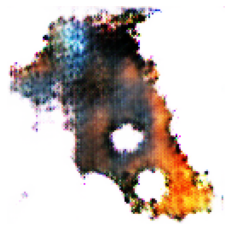

In [42]:
# generate and save images grid to pokemon.png
generate_random(num=1) # set number of images in quare grid (num = N^2) 